# Agenda
- To complexify the NN architecture, in particular, we will take more characters in a sequence as input not just 3.
- We will not just feed them all into 1 hidden layer because it squashes too much information too quickly.
- Instead we will make a deeper model that progressively fuses this information to make the guess of the next character in the sequence.

- We will arrive at an architecture very similar to a wavenet (a language model but it also predicts audio sequences not just char/word level sequences)
- An autoregressive model - takes a hierarchial approach with tree like structure.

In [52]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [54]:
len(words)

32033

In [55]:
# build vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars) }
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [56]:
# build the dataset
block_size = 8  # how many characters to predict

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context) # append the context
            Y.append(ix) # append the next character
            context = context[1:] + [ix] # crop and append the new character

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)  # shuffle the words to get a good mix
n1 = int(0.8 * len(words))  # 80% for training
n2 = int(0.9 * len(words)) # 10% for validation

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [57]:
for x, y in zip(Xtrain[:20], Ytrain[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [58]:
# From part -3 makemore

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1): # momentum is to keep track of the running mean and variance
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:  # if the input is a 2D tensor, we need to reshape it to a 1D tensor  e.g., (batch, features)
                dim = 0
            elif x.ndim == 3:  # if the input is a 3D tensor, we need to reshape it to a 2D tensor e.g., (batch, seq, features)
                dim =(0, 1)  # batch and sequence dimensions
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
            with torch.no_grad():  # update the running mean and variance using context manager to prevent gradient computation 
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
        
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape  # B: batch size, T: sequence length, C: number of features
        #self.out = x.view(x.shape[0], -1) # flatten the input tensor to a 2D tensor with shape (batch_size, -1). basically concatenate all the elements in the last dimension
        x = x.view(B, T // self.n, C * self.n)  # reshape to (B, T/n, C*n)
        if x.shape[1] == 1:
            x = x.squeeze(1) # remove the second dimension if it is 1
        self.out = x
        return self.out

    def parameters(self):
        return []

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()] # concatenate the parameters of all the layers in a single list.            

In [59]:
torch.manual_seed(42)

In [60]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

n_embd = 24  # embedding dimension
n_hidden = 128  # number of hidden neurons in the hidden layer

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),  
])

# Initialize the parameters
with torch.no_grad():
    model.layers[-1].weight *= 0.1 #5/3 # last layer: makes less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters
for p in parameters:
    p.requires_grad = True  # enable gradient computation for all parameters

76579


In [61]:
#illustration of the hidden layer when linear layer is applied, matrix multiplication '@' is used '+' bias
(torch.randn(4, 80) @ torch.randn(80, 200)  + torch.randn(200)).shape  # example of matrix multiplication in the hidden layer

torch.Size([4, 200])

In [62]:
# we want only 2 characters/numbers coming into the first layer not all 80. and those 2 characters should be fused - means only 20 numbers should be coming into the first layer
# Also we don't want (4, 80) to feed into the linear layer, we want (4, 20) to feed into the linear layer - it can be viewed as (4, 80) -> (4, 4, 20)

(torch.randn(4, 4, 20) @ torch.randn(20, 200)  + torch.randn(200)).shape
        # Hidden layer          

torch.Size([4, 4, 200])

In [63]:
list(range(10))[1::2] # list of odd numbers from 0 to 9

[1, 3, 5, 7, 9]

In [64]:
e = torch.randn(4, 8, 10)  # goal: we want this to be (4, 4, 20) where consecutive 10-d vectors are fused into 20-d vectors
explicit_concat =torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2).shape  
explicit_concat

torch.Size([4, 4, 20])

In [65]:
e.view(4, 4, 20).shape

torch.Size([4, 4, 20])

In [66]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
  Xb, Yb = Xtrain[ix], Ytrain[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3095
  10000/ 200000: 2.0891
  20000/ 200000: 2.4235
  30000/ 200000: 2.1769
  40000/ 200000: 1.9419
  50000/ 200000: 1.9380
  60000/ 200000: 2.1125
  70000/ 200000: 2.0225
  80000/ 200000: 2.0893
  90000/ 200000: 1.9620
 100000/ 200000: 1.7643
 110000/ 200000: 1.8953
 120000/ 200000: 1.5643
 130000/ 200000: 2.3322
 140000/ 200000: 2.0476
 150000/ 200000: 1.8052
 160000/ 200000: 1.7695
 170000/ 200000: 1.6950
 180000/ 200000: 1.3297
 190000/ 200000: 1.4935


In [67]:
torch.tensor(lossi).view(-1, 1000).mean(1).shape

torch.Size([200])

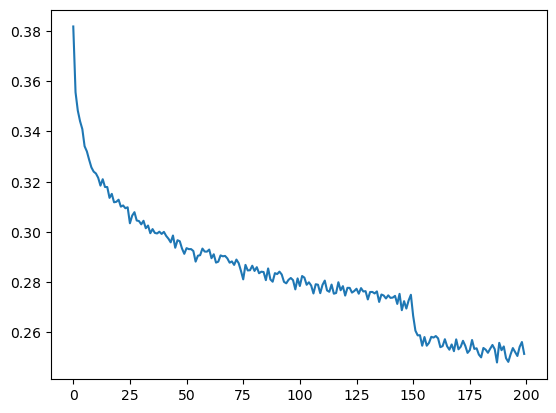

In [68]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [69]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [70]:
# evaluate train and val loss

@torch.no_grad() # decorator disable gradient computation for evaluation
def split_loss(split):
    x,y = {
        'train': (Xtrain, Ytrain),
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    } [split] # get the data for the split
    logits = model(x) # forward pass
    loss = F.cross_entropy(logits, y) # compute loss
    print(f'{split} loss: {loss.item():.4f}')

split_loss('train')
split_loss('val')

train loss: 1.7629
val loss: 1.9951


# performance log
- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993

In [71]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size  # start with a context of zeros
    while True:
        # forward pass:
        logits = x=model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)  # convert to probabilities
        ix = torch.multinomial(probs, num_samples=1).item()  # sample from the distribution
        if ix == 0: break  # stop if we hit the end token
        out.append(itos[ix])  # append the character to the output
        context = context[1:] + [ix]  # update the context

    print(''.join(out))  # print the generated name

fataleigh
chan
corbi
devan
anabella
estefany
brixta
filas
eledre
isata
limak
angel
keysha
daishna
gerson
keylan
iyan
jermany
faed
shylaene
